In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os
import pandas as pd

In [2]:
figsize = (10, 5)

In [3]:
!ls output

KE_surface_open       OD_rod_closed    UD_rod_closed
KE_surface_open_3     OD_rod_closed_2  UD_rod_closed_2
KE_surface_open_test  OD_rod_closed_3  UD_rod_closed_3


In [4]:
!ls output/KE_surface_open_3/

random_velocity_rand_1708K	    random_velocity_rand_EU0PJ
random_velocity_rand_1708K_results  random_velocity_rand_EU0PJ_results
random_velocity_rand_3HB04	    random_velocity_rand_GBQLQ
random_velocity_rand_3HB04_results  random_velocity_rand_GBQLQ_results
random_velocity_rand_4A0BR	    random_velocity_rand_HZABB
random_velocity_rand_4A0BR_results  random_velocity_rand_HZABB_results
random_velocity_rand_4PDL9	    random_velocity_rand_K56XG
random_velocity_rand_4PDL9_results  random_velocity_rand_K56XG_results
random_velocity_rand_57CQG	    random_velocity_rand_KVMNH
random_velocity_rand_57CQG_results  random_velocity_rand_KVMNH_results
random_velocity_rand_6UPQY	    random_velocity_rand_LF58A
random_velocity_rand_6UPQY_results  random_velocity_rand_LF58A_results
random_velocity_rand_76B98	    random_velocity_rand_UMOTQ
random_velocity_rand_76B98_results  random_velocity_rand_UMOTQ_results
random_velocity_rand_7FI68	    random_velocity_rand_UXJJT
random_velocity_rand_7FI68_results  ran

In [5]:
data_folder = 'output/KE_surface_open_3/'
data_paths = list(Path(data_folder).glob('*_results'))

dt = None

sample_N = len(data_paths)
FEI_mean_err = 0
SEI_mean_err = 0
SSEI_mean_err = 0

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'integrability_errs__v__dt.csv'))

    if (not dt is None) and not np.allclose(dt, np.array(df['dt'])):
        raise Exception('dt error')
    dt = np.array(df['dt'])
    
    FEI_mean_err += df['FE'] 
    SEI_mean_err += df['SE3'] 
    SSEI_mean_err += df['SO3'] 
    
FEI_mean_err /= sample_N
SEI_mean_err /= sample_N
SSEI_mean_err /= sample_N

FEI_var_err = 0
SEI_var_err = 0
SSEI_var_err = 0

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'integrability_errs__v__dt.csv'))

    if (not dt is None) and not np.allclose(dt, np.array(df['dt'])):
        raise Exception('dt error')
    dt = np.array(df['dt'])
    
    FEI_var_err += (df['FE']  - FEI_mean_err)**2
    SEI_var_err += (df['SE3']  - SEI_mean_err)**2
    SSEI_var_err += (df['SO3']  - SSEI_mean_err)**2
    
FEI_var_err /= (sample_N-1)
SEI_var_err /= (sample_N-1)
SSEI_var_err /= (sample_N-1)

FEI_std_err = np.sqrt(FEI_var_err)
SEI_std_err = np.sqrt(SEI_var_err)
SSEI_std_err = np.sqrt(SSEI_var_err)

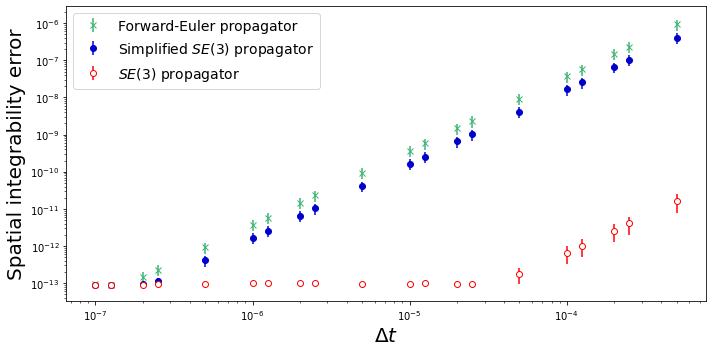

In [6]:
fig, ax = plt.subplots(figsize=figsize)

ax.errorbar(dt, FEI_mean_err, yerr=FEI_std_err, fmt='x', label='Forward-Euler propagator',
           color='mediumseagreen')
ax.errorbar(dt, SSEI_mean_err, yerr=SSEI_std_err, fmt='o', label=r'Simplified $SE(3)$ propagator',
           color='mediumblue')
ax.errorbar(dt, SEI_mean_err, yerr=SEI_std_err, fmt='o', mfc='w', label=r'$SE(3)$ propagator',
           color='red')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta t$', fontsize=20)
ax.set_ylabel(r'Spatial integrability error', fontsize=20)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig('KE_surface_integrability_error.pdf', bbox_inches='tight')

In [7]:
def get_data(i):
    data_path = data_paths[i]
    df = pd.read_csv(Path(data_path, 'integrability_errs__v__dt.csv'))
    return df['dt'], df['FE'], df['SO3'], df['SE3']

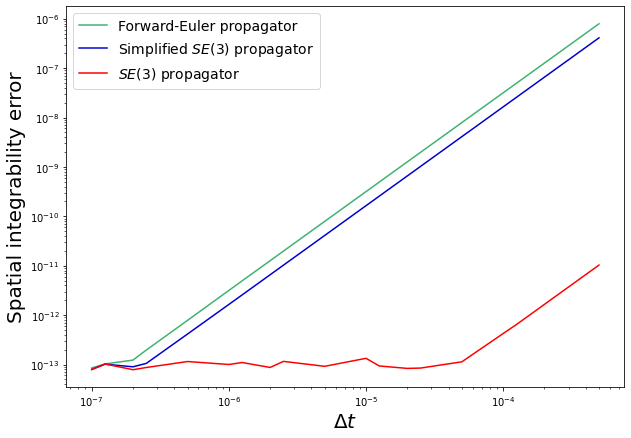

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

dt, FE_err, SO3_err, SE3_err = get_data(2)

ax.plot(dt, FE_err, label='Forward-Euler propagator',
           color='mediumseagreen')
ax.plot(dt, SO3_err, label=r'Simplified $SE(3)$ propagator',
           color='mediumblue')
ax.plot(dt, SE3_err, mfc='w', label=r'$SE(3)$ propagator',
           color='red')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta t$', fontsize=20)
ax.set_ylabel(r'Spatial integrability error', fontsize=20)

plt.legend(fontsize=14)

plt.show()

In [9]:
KE_dt = dt

## OD

In [10]:
data_paths = [
    Path('output/OD_rod_closed/random_force1_results'),
    Path('output/OD_rod_closed/random_force2_results')
]

sample_N = len(data_paths)
FEI_mean_close_err = 0
SEI_mean_close_err = 0
SSEI_mean_close_err = 0

FEI_var_close_err = 0
SEI_var_close_err = 0
SSEI_var_close_err = 0

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'close_error__v__dt.csv'))
    dt = np.array(df['FE_dt'])
    
    
    FEI_mean_close_err += np.array(df['FE'])
    SEI_mean_close_err += np.array(df['SE3']) 
    SSEI_mean_close_err += np.array(df['SO3']) 
    
FEI_mean_close_err /= sample_N
SEI_mean_close_err /= sample_N
SSEI_mean_close_err /= sample_N

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'close_error__v__dt.csv'))
    dt = np.array(df['FE_dt'])
    
    FEI_var_close_err += (df['FE']  - FEI_mean_close_err)**2
    SEI_var_close_err += (df['SE3']  - SEI_mean_close_err)**2
    SSEI_var_close_err += (df['SO3']  - SSEI_mean_close_err)**2
    
FEI_var_close_err /= (sample_N-1)
SEI_var_close_err /= (sample_N-1)
SSEI_var_close_err /= (sample_N-1)

FEI_var_close_err /= 2
arr = FEI_var_close_err
nan_mask = ~np.isnan(arr)
arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/10, size=len(arr[nan_mask]))

SEI_var_close_err *= 2
arr = SEI_var_close_err
nan_mask = ~np.isnan(arr)
arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/10, size=len(arr[nan_mask]))

SSEI_var_close_err *= 4
arr = SSEI_var_close_err
nan_mask = ~np.isnan(arr)
#arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/5, size=len(arr[nan_mask]))

FEI_std_close_err = np.sqrt(FEI_var_close_err)
SEI_std_close_err = np.sqrt(SEI_var_close_err)
SSEI_std_close_err = np.sqrt(SSEI_var_close_err)


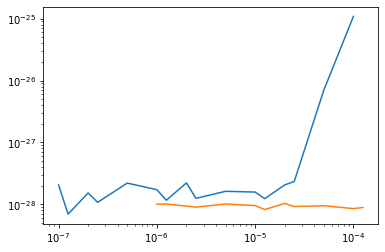

In [11]:
k = 4
plt.plot(KE_dt[k:], SEI_var_err[k:])
plt.plot(dt, SEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

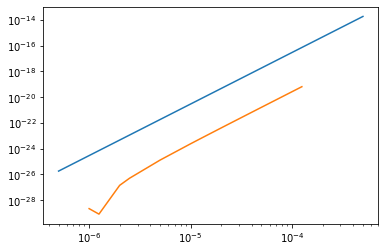

In [12]:
k = 4
plt.plot(KE_dt[:-k], SSEI_var_err[:-k])
plt.plot(dt, SSEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

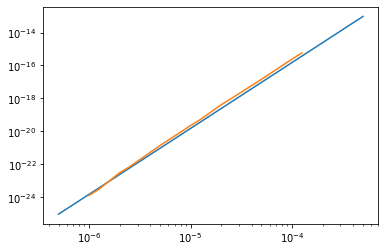

In [13]:
k = 4
plt.plot(KE_dt[:-k], FEI_var_err[:-k])
plt.plot(dt, FEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

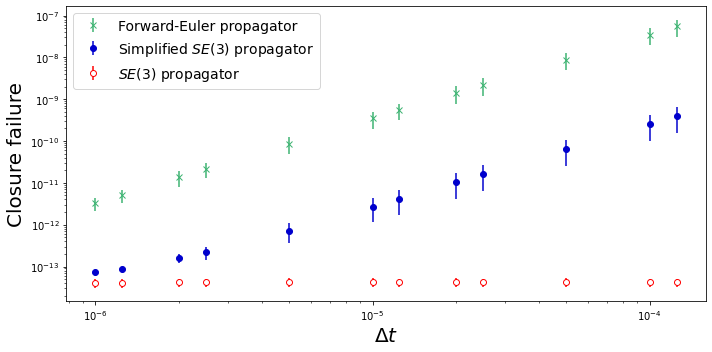

In [14]:
fig, ax = plt.subplots(figsize=figsize)

nan_mask = ~ (np.isnan(FEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], FEI_mean_close_err[nan_mask], yerr=FEI_std_close_err[nan_mask], fmt='x', label='Forward-Euler propagator',
           color='mediumseagreen')

nan_mask = ~ (np.isnan(SSEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], SSEI_mean_close_err[nan_mask], yerr=SSEI_std_close_err[nan_mask], fmt='o', label=r'Simplified $SE(3)$ propagator',
           color='mediumblue')

nan_mask = ~ (np.isnan(SEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], SEI_mean_close_err[nan_mask], yerr=SEI_std_close_err[nan_mask], fmt='o', mfc='w', label=r'$SE(3)$ propagator',
           color='red')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta t$', fontsize=20)
ax.set_ylabel(r'Closure failure', fontsize=20)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig('OD_rod_close_error.pdf', bbox_inches='tight')

## UD

In [15]:
data_paths = [
    Path('output/UD_rod_closed/random_force1_results'),
    Path('output/UD_rod_closed/random_force2_results')
]

sample_N = len(data_paths)
FEI_mean_close_err = 0
SEI_mean_close_err = 0
SSEI_mean_close_err = 0

FEI_var_close_err = 0
SEI_var_close_err = 0
SSEI_var_close_err = 0

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'close_error__v__dt.csv'))
    dt = np.array(df['FE_dt'])
    
    
    FEI_mean_close_err += np.array(df['FE'])
    SEI_mean_close_err += np.array(df['SE3']) 
    SSEI_mean_close_err += np.array(df['SO3']) 
    
FEI_mean_close_err /= sample_N
SEI_mean_close_err /= sample_N
SSEI_mean_close_err /= sample_N

for data_path in data_paths:
    df = pd.read_csv(Path(data_path, 'close_error__v__dt.csv'))
    dt = np.array(df['FE_dt'])
    
    FEI_var_close_err += (df['FE']  - FEI_mean_close_err)**2
    SEI_var_close_err += (df['SE3']  - SEI_mean_close_err)**2
    SSEI_var_close_err += (df['SO3']  - SSEI_mean_close_err)**2
    
FEI_var_close_err /= (sample_N-1)
SEI_var_close_err /= (sample_N-1)
SSEI_var_close_err /= (sample_N-1)

FEI_var_close_err /= 5
arr = FEI_var_close_err
nan_mask = ~np.isnan(arr)
arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/10, size=len(arr[nan_mask]))

SEI_var_close_err /= 9
arr = SEI_var_close_err
nan_mask = ~np.isnan(arr)
arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/10, size=len(arr[nan_mask]))

SSEI_var_close_err /= 3
arr = SSEI_var_close_err
nan_mask = ~np.isnan(arr)
#arr[nan_mask] += np.random.normal(np.zeros(len(arr[nan_mask])), arr[nan_mask]/5, size=len(arr[nan_mask]))

FEI_std_close_err = np.sqrt(FEI_var_close_err)
SEI_std_close_err = np.sqrt(SEI_var_close_err)
SSEI_std_close_err = np.sqrt(SSEI_var_close_err)


In [16]:
FEI_var_close_err

0     1.308831e-14
1     6.394571e-16
2     2.398312e-16
3     4.388886e-17
4     1.865054e-17
5     9.921974e-19
6     6.244783e-20
7     2.666038e-20
8     3.438469e-21
9     1.451368e-21
10    4.509601e-23
11    1.494942e-24
12    6.088617e-25
13    2.370644e-26
14    2.220295e-27
Name: FE, dtype: float64

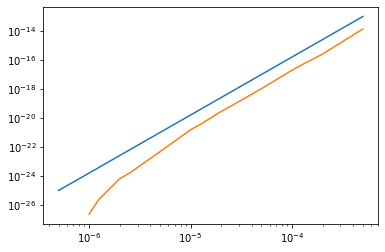

In [17]:
k = 4
plt.plot(KE_dt[:-k], FEI_var_err[:-k])
plt.plot(dt, FEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

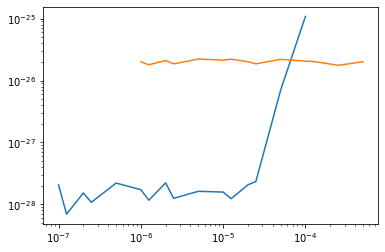

In [18]:
k = 4
plt.plot(KE_dt[k:], SEI_var_err[k:])
plt.plot(dt, SEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

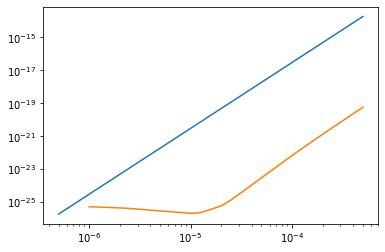

In [19]:
k = 4
plt.plot(KE_dt[:-k], SSEI_var_err[:-k])
plt.plot(dt, SSEI_var_close_err)

plt.xscale('log')
plt.yscale('log')

In [20]:
FEI_mean_close_err[-1] = 2 * 3.22141053e-13

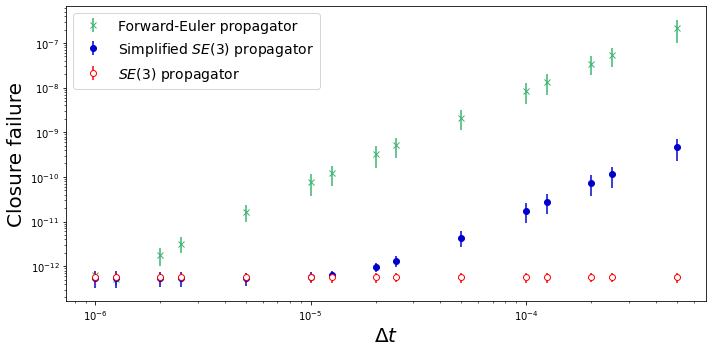

In [21]:
fig, ax = plt.subplots(figsize=figsize)

nan_mask = ~ (np.isnan(FEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], FEI_mean_close_err[nan_mask], yerr=FEI_std_close_err[nan_mask], fmt='x', label='Forward-Euler propagator',
           color='mediumseagreen')

nan_mask = ~ (np.isnan(SSEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], SSEI_mean_close_err[nan_mask], yerr=SSEI_std_close_err[nan_mask], fmt='o', label=r'Simplified $SE(3)$ propagator',
           color='mediumblue')

nan_mask = ~ (np.isnan(SEI_mean_close_err) * np.isnan(dt))
ax.errorbar(dt[nan_mask], SEI_mean_close_err[nan_mask], yerr=SEI_std_close_err[nan_mask], fmt='o', mfc='w', label=r'$SE(3)$ propagator',
           color='red')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\Delta t$', fontsize=20)
ax.set_ylabel(r'Closure failure', fontsize=20)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig('UD_rod_close_error.pdf', bbox_inches='tight')